In [273]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import pywt
import pandas as pd
import scipy.stats as stats

from scipy.io import loadmat

from sklearn.decomposition import PCA
from sklearn.decomposition import NMF
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap

### Load the data

In [274]:
# load the data
n_subj = 27

emg_data_E1={}
stimulus_E1={}
repetition_E1={}

for i in range(n_subj):
    data_E1 = loadmat("data/S%d_A1_E1.mat"%(i+1))
    emg_data_E1[i] = data_E1["emg"]
    stimulus_E1[i] = data_E1["stimulus"]
    repetition_E1[i] = data_E1["repetition"]

In [275]:
# store sizes
n_channels = emg_data_E1[0].shape[1]
n_stimuli = int(np.unique(stimulus_E1[0]).size - 1)  # remove rest
n_repetitions = int(np.unique(repetition_E1[0]).size - 1)  # remove rest

n_epochs = n_stimuli * n_repetitions
n_tsteps = 500 #because of subject 13

In [276]:
emg_tensor_E1 = np.zeros((n_subj, n_stimuli, n_repetitions, n_tsteps, n_channels))
for n in range(n_subj):
    for i in range(n_stimuli):
        for j in range(n_repetitions):
            sel = np.squeeze(np.logical_and(stimulus_E1[n] == (i + 1), repetition_E1[n] == (j + 1)))
            emg_selected_data = emg_data_E1[n][sel, :]
            emg_tensor_E1[n, i, j, :, :] = emg_selected_data[:n_tsteps, :]

In [277]:
emg_tensor_E1.shape

(27, 12, 10, 500, 10)

In [278]:
# Example of features
def features_estimation(signal, fs):
    """
    Compute time, frequency and time-frequency features from signal.
    :param signal: numpy array signal.
    :param channel_name: string variable with the EMG channel name in analysis.
    :param fs: int variable with the sampling frequency used to acquire the signal
    :return: total_feature_matrix -- python list
    :return: features_names -- python list with
    """

    features_names = ['VAR', 'RMS', 'IEMG', 'MAV', 'LOG', 'WL', 'ACC', 'DASDV', 'ZC', 'WAMP', 'MYOP', "MNP", "TP",
                      "MNF", "MDF", "PKF", "WENT"]

    time_matrix = time_features_estimation(signal)
    frequency_matrix = frequency_features_estimation(signal, fs)
    time_frequency_matrix = time_frequency_features_estimation(signal)
    total_feature_matrix = np.column_stack((time_matrix, frequency_matrix, time_frequency_matrix))

    return total_feature_matrix


def time_features_estimation(signal):
    """
    Compute time features from signal
    :param signal: numpy array signal.
    """

    th = np.mean(signal) + 3 * np.std(signal)

    variance = (np.var(signal))
    rms = (np.sqrt(np.mean(signal ** 2)))
    iemg = (np.sum(abs(signal)))  # Integral
    mav = (np.sum(np.absolute(signal)) / len(signal))  # Mean Absolute Value
    log_detector = (np.exp(np.sum(np.log10(np.absolute(signal))) / len(signal)))
    wl = (np.sum(abs(np.diff(signal))))  # Wavelength
    aac = (np.sum(abs(np.diff(signal))) / len(signal))  # Average Amplitude Change
    dasdv = (math.sqrt((1 / (len(signal) - 1)) * np.sum((np.diff(signal)) ** 2)))  # Difference absolute standard deviation value
    zc = (zcruce(signal, th))  # Zero-Crossing
    wamp = (wilson_amplitude(signal, th))  # Willison amplitude
    myop = (myopulse(signal, th))  # Myopulse percentage rate

    time_features_matrix = np.column_stack((variance, rms, iemg, mav, log_detector, wl, aac, dasdv, zc, wamp, myop))
    return time_features_matrix


def frequency_features_estimation(signal, fs):
    """
    Compute frequency features from signal
    :param signal: numpy array signal.
    :param fs: sampling frequency of the signal.
    :return: frequency_features_matrix: narray matrix with the frequency features stacked by columns.
    """

    frequency, power = spectrum(signal, fs)
    
    mnp = (np.sum(power) / len(power))  # Mean power
    tot = (np.sum(power))  # Total power
    mnf = (mean_freq(frequency, power))  # Mean frequency
    mdf = (median_freq(frequency, power))  # Median frequency
    pkf = (frequency[power.argmax()])  # Peak frequency

    frequency_features_matrix = np.column_stack((mnp, tot, mnf, mdf, pkf))

    return frequency_features_matrix


def time_frequency_features_estimation(signal):
    """
    Compute time-frequency features from signal
    :param signal: numpy array signal.
    :return: h_wavelet: list
    """
    h_wavelet = []

    E_a, E = wavelet_energy(signal, 'db2', 4)
    E.insert(0, E_a)
    E = np.asarray(E) / 100

    h_wavelet.append(-np.sum(E * np.log2(E)))

    return h_wavelet


def wilson_amplitude(signal, th):
    x = abs(np.diff(signal))
    umbral = x >= th
    return np.sum(umbral)


def myopulse(signal, th):
    umbral = signal >= th
    return np.sum(umbral) / len(signal)


def spectrum(signal, fs):
    m = len(signal)
    n = next_power_of_2(m)
    y = np.fft.fft(signal, n)
    yh = y[0:int(n / 2 - 1)]
    fh = (fs / n) * np.arange(0, n / 2 - 1, 1)
    power = np.real(yh * np.conj(yh) / n)

    return fh, power

def shannon(x):
    N = len(x)
    nb = 19
    hist, bin_edges = np.histogram(x, bins=nb)
    counts = hist / N
    nz = np.nonzero(counts)

    return np.sum(counts[nz] * np.log(counts[nz]) / np.log(2))


def zcruce(X, th):
    th = 0
    cruce = 0
    for cont in range(len(X) - 1):
        can = X[cont] * X[cont + 1]
        can2 = abs(X[cont] - X[cont + 1])
        if can < 0 and can2 > th:
            cruce = cruce + 1
    return cruce


def mean_freq(frequency, power):
    num = 0
    den = 0
    for i in range(int(len(power) / 2)):
        num += frequency[i] * power[i]
        den += power[i]

    return num / den


def median_freq(frequency, power):
    power_total = np.sum(power) / 2
    temp = 0
    tol = 0.01
    errel = 1
    i = 0

    while abs(errel) > tol:
        temp += power[i]
        errel = (power_total - temp) / power_total
        i += 1
        if errel < 0:
            errel = 0
            i -= 1

    return frequency[i]


def wavelet_energy(x, mother, nivel):
    coeffs = pywt.wavedecn(x, wavelet=mother, level=nivel)
    arr, _ = pywt.coeffs_to_array(coeffs)
    Et = np.sum(arr ** 2)
    cA = coeffs[0]
    Ea = 100 * np.sum(cA ** 2) / Et
    Ed = []

    for k in range(1, len(coeffs)):
        cD = list(coeffs[k].values())
        cD = np.asarray(cD)
        Ed.append(100 * np.sum(cD ** 2) / Et)

    return Ea, Ed


def next_power_of_2(x):
    return 1 if x == 0 else 2 ** (x - 1).bit_length()


def med_freq(f, P):
    Ptot = np.sum(P) / 2
    temp = 0
    tol = 0.01
    errel = 1
    i = 0

    while abs(errel) > tol:
        temp += P[i]
        errel = (Ptot - temp) / Ptot
        i += 1
        if errel < 0:
            errel = 0
            i -= 1

    return f[i]

In [279]:
fs = 100 # set frequency
out = features_estimation(signal=emg_tensor_E1[0, 0, 0, :, 1], fs=100)
out.shape

(1, 17)

In [280]:
print("n_stimuli : ", n_stimuli)
print("n_repetitions : ", n_repetitions)
print("n_channels : ", n_channels)

n_stimuli :  12
n_repetitions :  10
n_channels :  10


In [281]:
# extract all the features with using features_estimation
emg_features = {}
labels_dict = {}
for n in range(n_subj):
    all_feature_list = []
    labels = []
    for i in range(n_stimuli):
        for j in range(n_repetitions):
            channelwise_feature_list = []
            for k in range(n_channels):
                current_channel_features = features_estimation(signal=emg_tensor_E1[n, i, j, :, k], fs=fs)
                channelwise_feature_list.append(current_channel_features)
            channelwise_features = np.hstack(channelwise_feature_list)
            all_feature_list.append(channelwise_features)
            labels.append(i)
            
    # store for each subject
    emg_features[n] = np.vstack(all_feature_list)
    labels_dict[n] = np.array(labels)

<ipython-input-278-39a8a1dd7d0b>:35: RuntimeWarning: divide by zero encountered in log10
  log_detector = (np.exp(np.sum(np.log10(np.absolute(signal))) / len(signal)))


In [282]:
feature_names = [
    "VAR", "RMS", "IEMG", "MAV", "LOG", 
    "WL", "ACC", "DASDV", "ZC", "WAMP", 
    "MYOP", "MNP", "TP", "MNF", "MDF",
    "PKF", "WENT"
]
n_features_per_channel = len(feature_names)

<AxesSubplot:>

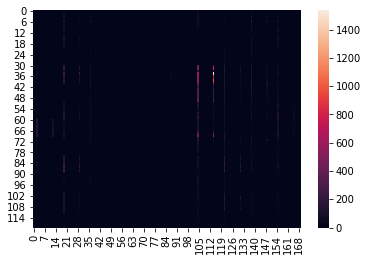

In [283]:
# check for meaningless features
fig, ax = plt.subplots()
sns.heatmap(data=emg_features[0])

<AxesSubplot:>

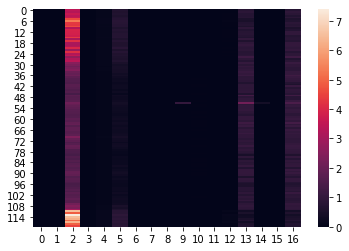

In [284]:
fig, ax = plt.subplots()
sns.heatmap(data=emg_features[10][:, :n_features_per_channel], ax=ax)

In [285]:
np.expand_dims(np.min(emg_features, axis=0), axis=0).shape

(1,)

<ipython-input-286-a38e74170c71>:7: RuntimeWarning: invalid value encountered in true_divide
  emg_minmax = (emg_features[n] - emg_mins) / (emg_maxs - emg_mins)


<AxesSubplot:>

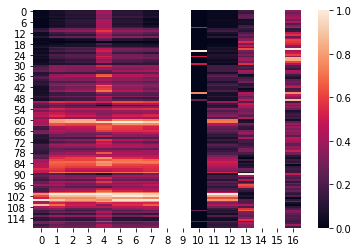

In [286]:
n=1
emg_mins = np.expand_dims(np.min(emg_features[n], axis=0), axis=0)
emg_maxs = np.expand_dims(np.max(emg_features[n], axis=0), axis=0)
emg_mins = np.tile(emg_mins, [emg_features[n].shape[0], 1])
emg_maxs = np.tile(emg_maxs, [emg_features[n].shape[0], 1])

emg_minmax = (emg_features[n] - emg_mins) / (emg_maxs - emg_mins)
fig, ax = plt.subplots()
sns.heatmap(emg_minmax[:, :n_features_per_channel], ax=ax)

In [287]:
emg_features[0].shape

(120, 170)

Features 8, 9 and 15 are meaningless.

# TODO : See with feature 14

<ipython-input-288-c9051e0192c4>:16: RuntimeWarning: invalid value encountered in true_divide
  emg_minmax = (emg_features_ok[n] - emg_mins) / (emg_maxs - emg_mins)


<AxesSubplot:>

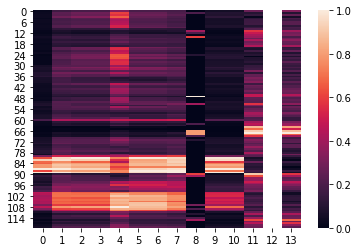

In [288]:
# feature 8, 9, 15 are meaningless for these data
feature_8 = np.arange(start=8, stop=170, step=17)
feature_9 = np.arange(start=9, stop=170, step=17)
feature_15 = np.arange(start=15, stop=170, step=17)
bad_cols = np.hstack((feature_8, feature_9, feature_15))
emg_features_ok = {}
for n in range(n_subj):
    emg_features_ok[n] = np.delete(emg_features[n], bad_cols, 1)

n=20
emg_mins = np.expand_dims(np.min(emg_features_ok[n], axis=0), axis=0)
emg_maxs = np.expand_dims(np.max(emg_features_ok[n], axis=0), axis=0)
emg_mins = np.tile(emg_mins, [emg_features_ok[n].shape[0], 1])
emg_maxs = np.tile(emg_maxs, [emg_features_ok[n].shape[0], 1])

emg_minmax = (emg_features_ok[n] - emg_mins) / (emg_maxs - emg_mins)
fig, ax = plt.subplots()
sns.heatmap(emg_minmax[:, :(n_features_per_channel - 3)], ax=ax)

In [289]:
emg_features_ok[2].shape

(120, 140)

### See the correlation between the features

In [290]:
feature_names = [
    "VAR", "RMS", "IEMG", "MAV", "LOG", "WL", 
    "ACC", "DASDV", "MYOP", "MNP", "TP", 
    "MNF", "PKF", "WENT"]

[]

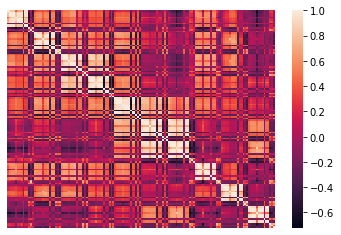

In [291]:
# correlation
n=16

all_feature_crosscorr = np.corrcoef(emg_features_ok[n].T)
fig, ax = plt.subplots()
sns.heatmap(data=all_feature_crosscorr, ax=ax)
ax.set_xticks([])
ax.set_yticks([])

### Normalize data

In [292]:
from scipy.stats import zscore

In [293]:
emg_features_norm = {}
for n in range(n_subj):
    emg_features_norm[n] = zscore(emg_features_ok[n], axis=1)

## Reshape the data 

In [294]:
labels_dict[5].shape

(120,)

In [295]:
# create n_subj dictionnnaray 
df_dict={}

for n in range(n_subj):
    # each one contains n_repetitions of the task
    df_dict[n]={}
    for k in range(n_repetitions):
        df_dict[n][k] = pd.DataFrame(emg_features_norm[n][:,(k*14):14*(k+1)], columns=feature_names)
        df_dict[n][k]['label']=labels_dict[n]


In [296]:
df_dict[1][9].head(15)

,VAR,RMS,IEMG,MAV,LOG,WL,ACC,DASDV,MYOP,MNP,TP,MNF,PKF,WENT,label
0,-0.287188,-0.284779,0.544863,-0.285616,-0.281138,-0.224311,-0.287154,-0.287061,-0.286677,-0.287047,-0.227875,-0.277045,-0.287280,-0.277788,0
1,-0.266374,-0.264920,0.239520,-0.265409,-0.262311,-0.224915,-0.266337,-0.266279,-0.266420,-0.266299,-0.235525,-0.258024,-0.266420,-0.257984,0
2,-0.285193,-0.282392,0.700402,-0.283430,-0.280709,-0.220524,-0.285272,-0.285173,-0.285402,-0.284894,-0.156057,-0.280003,-0.285402,-0.280819,0
3,-0.292090,-0.288990,0.769558,-0.290323,-0.288490,-0.237075,-0.292336,-0.292250,-0.292447,-0.291677,-0.096222,-0.288880,-0.292447,-0.290862,0
4,-0.279794,-0.277705,0.478398,-0.278377,-0.275162,-0.224949,-0.279784,-0.279713,-0.279894,-0.279616,-0.209068,-0.274413,-0.279894,-0.275359,0
5,-0.292787,-0.290126,0.732455,-0.290920,-0.287849,-0.235020,-0.292855,-0.292793,-0.292970,-0.292404,-0.148556,-0.289901,-0.292970,-0.290490,0
6,-0.291487,-0.288612,0.760215,-0.289635,-0.287148,-0.234339,-0.291624,-0.291552,-0.291738,-0.291089,-0.126174,-0.288380,-0.291738,-0.288892,0
7,-0.295774,-0.292300,1.091731,-0.293325,-0.290853,-0.221391,-0.295951,-0.295877,-0.296101,-0.295058,-0.030093,-0.293422,-0.296101,-0.293940,0
8,-0.289841,-0.286850,0.933023,-0.287611,-0.284625,-0.212355,-0.289902,-0.289822,-0.290057,-0.289263,-0.087412,-0.286575,-0.290057,-0.286457,0
9,-0.292344,-0.289722,0.670918,-0.290643,-0.288114,-0.232823,-0.292450,-0.292388,-0.292570,-0.291980,-0.142139,-0.289448,-0.292570,-0.290209,0


# Task 1. 
***Extract the same set of features from the signals acquired from different subjects. Look at the typical values of such features across the same set of movements for different subjects. Do you see any regularity?***

### Variation of the features for the same subject but on different repetitions

### Distribution

In [297]:
# set the value of the choosen stimuli
S=2

# number of features 
n_features = len(feature_names)

# choose the 2 pateints to compare 
N1 = 0  # male right handed 
N2 = 13  # left handed female

# feature names 
names = feature_names

# select the 2 sub-dataframes to compare
df_1 = df_dict[N1][0][df_dict[N1][0]['label']==S]
df_2 = df_dict[N2][0][df_dict[N2][0]['label']==S]
print(df_1.shape)

# stack all the repetitions together
for k in range(1, n_repetitions):
    df_1 = pd.concat([df_1, df_dict[N1][k][df_dict[N1][k]['label']==S]], axis = 0, ignore_index=True)
    df_2 = pd.concat([df_2, df_dict[N2][k][df_dict[N2][k]['label']==S]], axis = 0, ignore_index=True)

(10, 15)


DISTRIBUTION OF EACH FEATURES : patient 0 VS patient 13


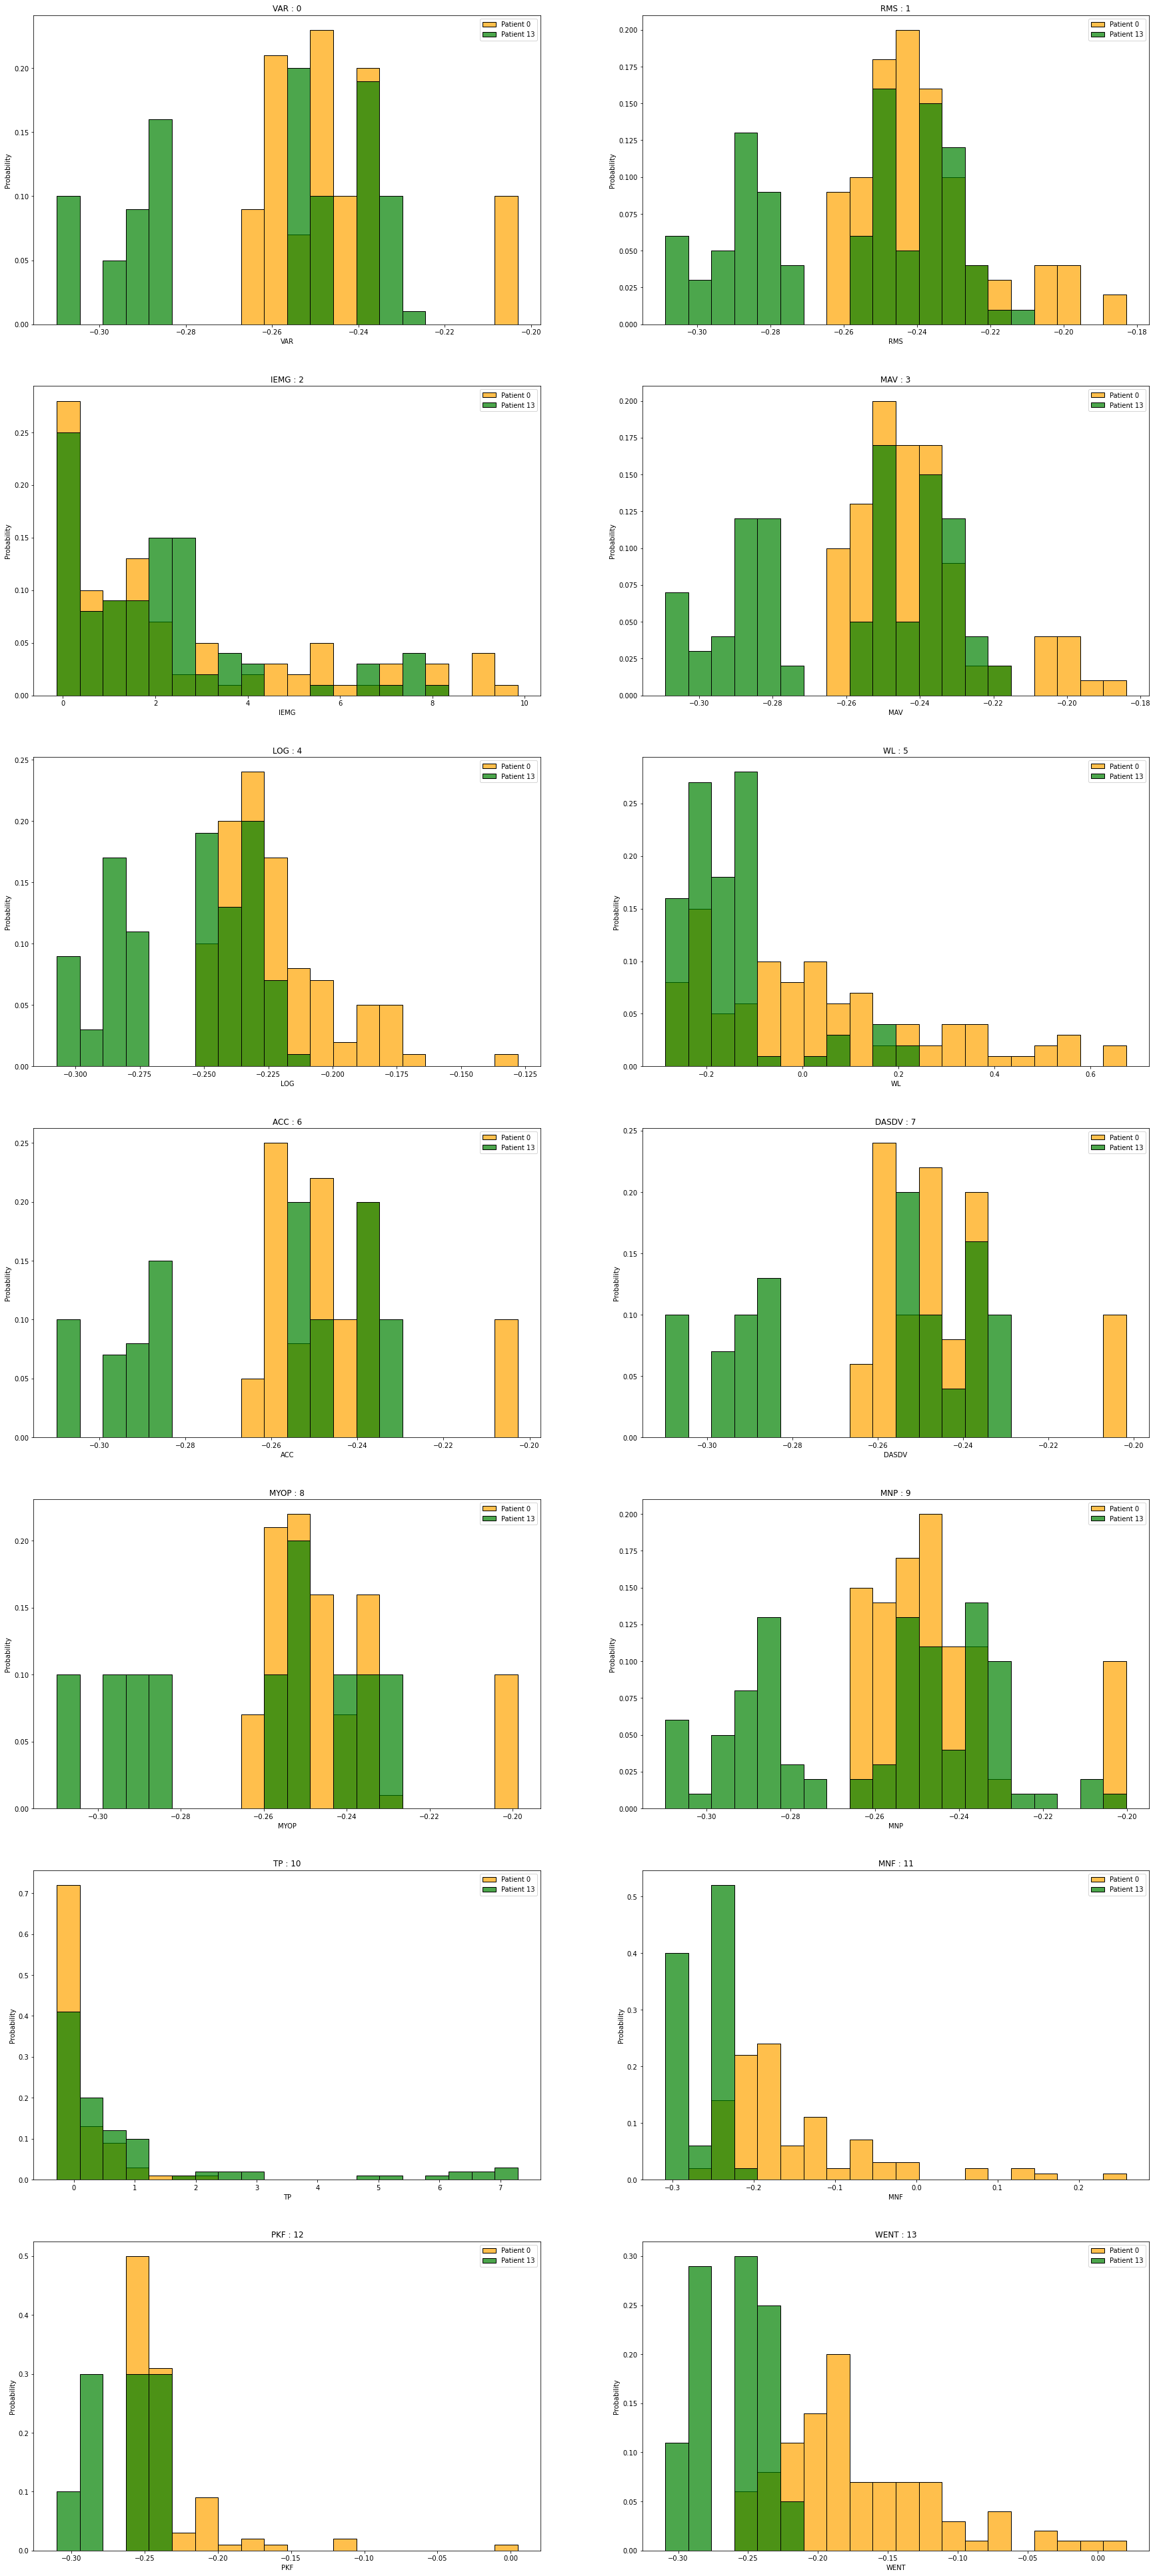

In [298]:
print("DISTRIBUTION OF EACH FEATURES : patient {0:d} VS patient {1:d}".format(N1, N2))
plt.figure(figsize=(30, 10*np.int32(np.ceil(n_features/2))))
for i in range(n_features):
        plt.subplot(np.int32(np.ceil(n_features/2)), 2, i+1)
        
        #binwidth=(np.max(x0)-np.min(x0))/20
        
        x0 = df_1.iloc[:,i]
        x1 = df_2.iloc[:,i]
        
        bins = 20
        bins = np.histogram(np.hstack((x0, x1)), bins=bins)[1]
        ax0 = sns.histplot(x0, stat='probability', bins=bins, color='orange', alpha=0.7, label='Patient {0:d}'.format(N1))
        ax1 = sns.histplot(x1, stat='probability', bins=bins, color='green', alpha=0.7, label='Patient {0:d}'.format(N2))
        
        plt.title(names[i]+" : %d" %i)
        plt.legend()
        

Here we can observe large difference between patients 0 and patient 13. For some features like IEMG (2) and TP (10), distribution looks the same but for the other features, it looks to be be very different.

### Correlation matrix

[Text(0, 0.5, 'VAR'),
 Text(0, 1.5, 'RMS'),
 Text(0, 2.5, 'IEMG'),
 Text(0, 3.5, 'MAV'),
 Text(0, 4.5, 'LOG'),
 Text(0, 5.5, 'WL'),
 Text(0, 6.5, 'ACC'),
 Text(0, 7.5, 'DASDV'),
 Text(0, 8.5, 'MYOP'),
 Text(0, 9.5, 'MNP'),
 Text(0, 10.5, 'TP'),
 Text(0, 11.5, 'MNF'),
 Text(0, 12.5, 'PKF'),
 Text(0, 13.5, 'WENT')]

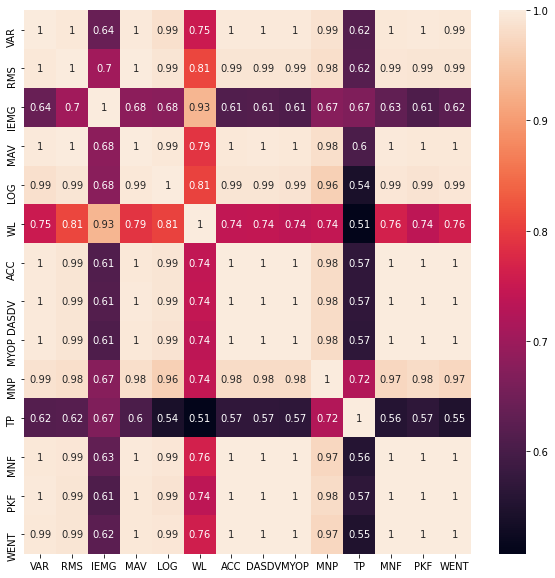

In [299]:
# select subject
N = 1

# select only features for one channel to see cross-correlations
feature_crosscorr = np.corrcoef(emg_features_norm[N][:, :n_features].T)

fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(data=feature_crosscorr, ax=ax, annot=True)
ax.set_xticklabels(feature_names)
ax.set_yticklabels(feature_names)

# Task 2. 
***Perform classification on different subjects separately. Rank the feature with respect to their relevance to classification. Are the sets of relevant features stable across different subjects?***

## Split the Data for the model

In [300]:
# create n_subj dictionnnaray 
data_27=np.zeros((n_repetitions*n_subj*120, n_features))
labels_27=np.zeros((n_repetitions*n_subj*120))

for n in range(n_subj):
    for k in range(n_repetitions):
        for i in range(n_epochs):
            data_27[n*n_repetitions*n_epochs+k*n_epochs+i] = emg_features_norm[n][:,(k*14):14*(k+1)][i]
            labels_27[n*n_repetitions*n_epochs+k*n_epochs+i] = labels_dict[n][i]
            

## Train classifiers on all subjects

Dans la 2 tu train sur tous et tu regardes les weights de ton modèles,      
La 3 tu repères des paires similaires, train sur un et évalue sur l’autre    
La 4 tu train sur un subset de n sujets et tu évalues sur un autre, en augmentant n au fur et à mesure

In [301]:
X_train={}
X_test={}
y_train={}
y_test={}
for n in range(n_subj):
    # X features, y labels
    X_train[n], X_test[n], y_train[n], y_test[n] = train_test_split(emg_features_norm[n], labels_dict[n], test_size=0.2)

### Train an SVM classifier on all subjects

In [302]:
from sklearn.model_selection import train_test_split
from sklearn import svm

In [303]:
clf={}
for n in range(n_subj):
    # init model
    clf[n] = svm.SVC(kernel='linear', verbose=True)
    # train model
    clf[n].fit(X_train[n], y_train[n])

[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]

In [304]:
y_hat={}
error={}
accuracy_svm={}
for n in range(n_subj): 
    y_hat[n]=clf[n].predict(X_test[n])
    error[n]=len(np.where((y_hat[n]-y_test[n])!=0)[0])
    accuracy_svm[n] = 1-(error[n]/len(y_hat[n]))
    print("Accuracy of the SVM model for subject {0:d}: {1:.2f}".format(n, accuracy_svm[n]))

Accuracy of the SVM model for subject 0: 0.83
Accuracy of the SVM model for subject 1: 0.88
Accuracy of the SVM model for subject 2: 0.96
Accuracy of the SVM model for subject 3: 0.88
Accuracy of the SVM model for subject 4: 1.00
Accuracy of the SVM model for subject 5: 0.83
Accuracy of the SVM model for subject 6: 1.00
Accuracy of the SVM model for subject 7: 0.92
Accuracy of the SVM model for subject 8: 0.92
Accuracy of the SVM model for subject 9: 1.00
Accuracy of the SVM model for subject 10: 0.92
Accuracy of the SVM model for subject 11: 0.92
Accuracy of the SVM model for subject 12: 1.00
Accuracy of the SVM model for subject 13: 0.96
Accuracy of the SVM model for subject 14: 0.96
Accuracy of the SVM model for subject 15: 0.96
Accuracy of the SVM model for subject 16: 1.00
Accuracy of the SVM model for subject 17: 0.88
Accuracy of the SVM model for subject 18: 0.96
Accuracy of the SVM model for subject 19: 0.92
Accuracy of the SVM model for subject 20: 1.00
Accuracy of the SVM mod

The model predicts very well on a subject.

### Train an KNN classifier on all subjects

In [305]:
from sklearn.neighbors import KNeighborsClassifier

knn_model = {}
y_hat={}
error={}
accuracy_knn={}

#number of neighbours = 3
for n in range(n_subj):
    # init model
    knn_model[n] = KNeighborsClassifier(3)
    # train model
    knn_model[n].fit(X_train[n],y_train[n])
    
    y_hat[n]=knn_model[n].predict(X_test[n])
    error[n]=len(np.where((y_hat[n]-y_test[n])!=0)[0])
    accuracy_knn[n] = 1-(error[n]/len(y_hat[n]))
    print("Accuracy of the KNN model for subject {0:d}: {1:.2f}".format(n, accuracy_knn[n]))

Accuracy of the KNN model for subject 0: 0.75
Accuracy of the KNN model for subject 1: 0.75
Accuracy of the KNN model for subject 2: 0.96
Accuracy of the KNN model for subject 3: 0.79
Accuracy of the KNN model for subject 4: 0.96
Accuracy of the KNN model for subject 5: 0.79
Accuracy of the KNN model for subject 6: 0.96
Accuracy of the KNN model for subject 7: 0.96
Accuracy of the KNN model for subject 8: 0.88
Accuracy of the KNN model for subject 9: 0.96
Accuracy of the KNN model for subject 10: 0.83
Accuracy of the KNN model for subject 11: 0.92
Accuracy of the KNN model for subject 12: 0.96
Accuracy of the KNN model for subject 13: 0.83
Accuracy of the KNN model for subject 14: 0.96
Accuracy of the KNN model for subject 15: 0.88
Accuracy of the KNN model for subject 16: 0.96
Accuracy of the KNN model for subject 17: 0.75
Accuracy of the KNN model for subject 18: 0.79
Accuracy of the KNN model for subject 19: 0.88
Accuracy of the KNN model for subject 20: 0.96
Accuracy of the KNN mod

### Train a Random Forest classifier on all subjects

In [306]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification

randomForest_model = {}
y_hat={}
error={}
accuracy_random={}

for n in range(n_subj):
    # init model
    randomForest_model[n] = RandomForestClassifier(max_depth=2, random_state=0)
    # train model
    randomForest_model[n].fit(X_train[n],y_train[n])
    
    y_hat[n]=randomForest_model[n].predict(X_test[n])
    error[n]=len(np.where((y_hat[n]-y_test[n])!=0)[0])
    accuracy_random[n] = 1-(error[n]/len(y_hat[n]))
    print("Accuracy of the Random Forest model for subject {0:d}: {1:.2f}".format(n, accuracy_random[n]))

Accuracy of the Random Forest model for subject 0: 0.58
Accuracy of the Random Forest model for subject 1: 0.54
Accuracy of the Random Forest model for subject 2: 0.67
Accuracy of the Random Forest model for subject 3: 0.46
Accuracy of the Random Forest model for subject 4: 0.75
Accuracy of the Random Forest model for subject 5: 0.50
Accuracy of the Random Forest model for subject 6: 0.62
Accuracy of the Random Forest model for subject 7: 0.62
Accuracy of the Random Forest model for subject 8: 0.54
Accuracy of the Random Forest model for subject 9: 0.33
Accuracy of the Random Forest model for subject 10: 0.71
Accuracy of the Random Forest model for subject 11: 0.75
Accuracy of the Random Forest model for subject 12: 0.75
Accuracy of the Random Forest model for subject 13: 0.58
Accuracy of the Random Forest model for subject 14: 0.58
Accuracy of the Random Forest model for subject 15: 0.79
Accuracy of the Random Forest model for subject 16: 0.79
Accuracy of the Random Forest model for s

### Accuracy comparison between the models across the 27 subjects

In [307]:
models_name = ['SVM','KNN','Random Forest']
accuracy ={'SVM':accuracy_svm, 'KNN':accuracy_knn, 'Random Forest':accuracy_random}

accuracies_df=pd.DataFrame.from_dict(accuracy)
print(accuracies_df)

         SVM       KNN  Random Forest
0   0.833333  0.750000       0.583333
1   0.875000  0.750000       0.541667
2   0.958333  0.958333       0.666667
3   0.875000  0.791667       0.458333
4   1.000000  0.958333       0.750000
5   0.833333  0.791667       0.500000
6   1.000000  0.958333       0.625000
7   0.916667  0.958333       0.625000
8   0.916667  0.875000       0.541667
9   1.000000  0.958333       0.333333
10  0.916667  0.833333       0.708333
11  0.916667  0.916667       0.750000
12  1.000000  0.958333       0.750000
13  0.958333  0.833333       0.583333
14  0.958333  0.958333       0.583333
15  0.958333  0.875000       0.791667
16  1.000000  0.958333       0.791667
17  0.875000  0.750000       0.458333
18  0.958333  0.791667       0.625000
19  0.916667  0.875000       0.541667
20  1.000000  0.958333       0.708333
21  0.916667  0.875000       0.583333
22  1.000000  1.000000       0.791667
23  0.833333  0.708333       0.625000
24  1.000000  0.958333       0.625000
25  0.916667

The best model is SVM, it is always the most accurate except in subject 7, 9, 12.

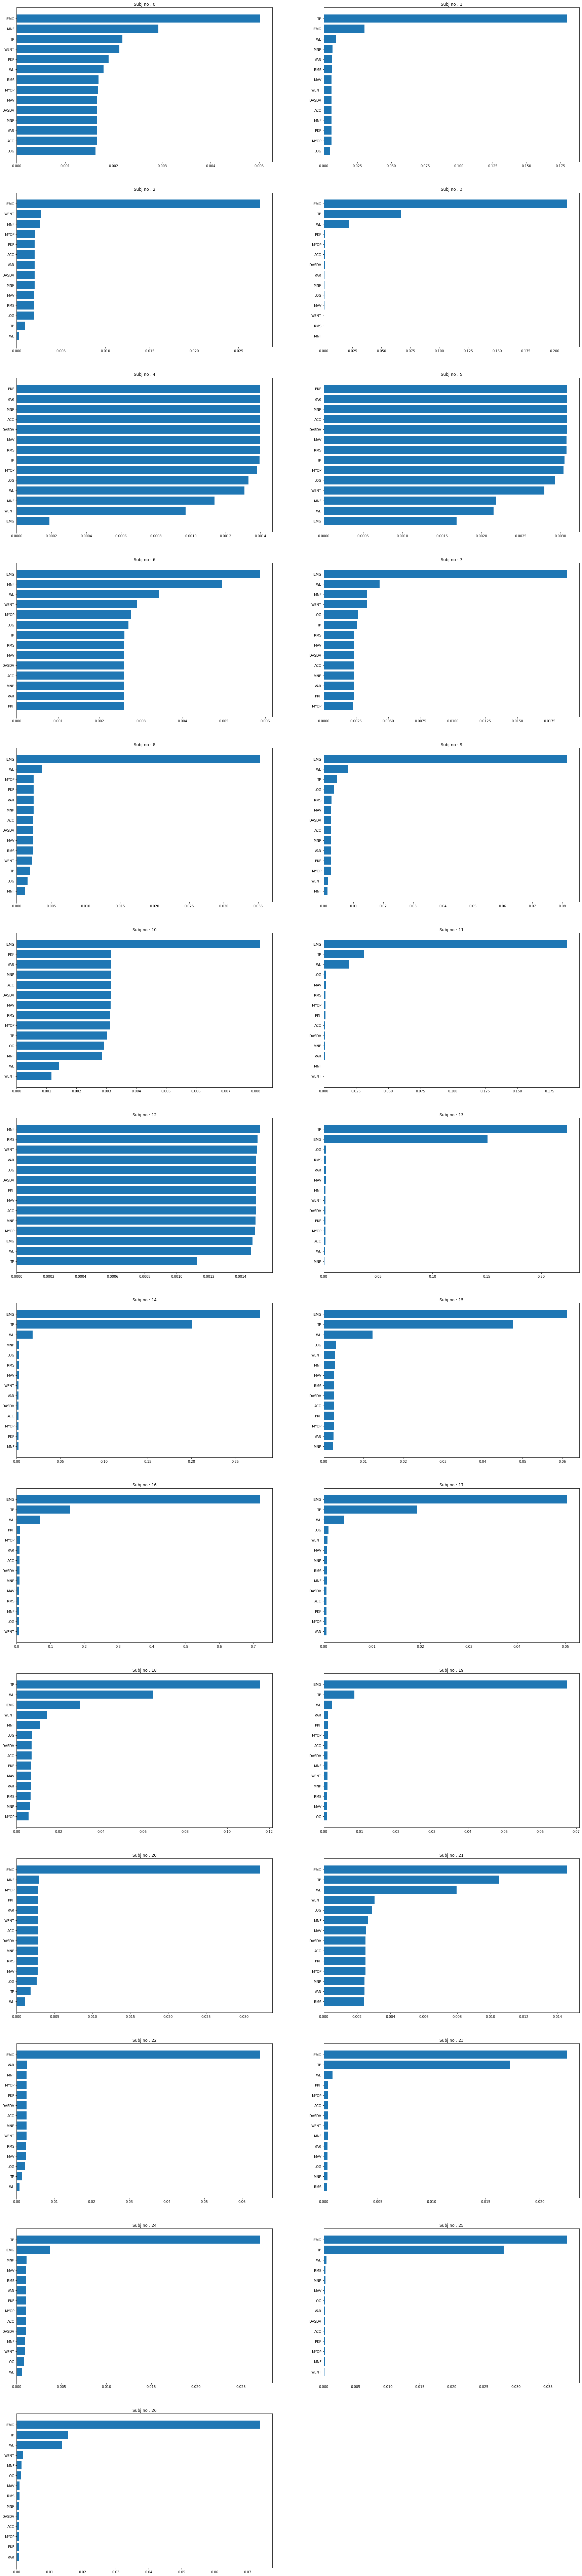

In [308]:
def f_importances(coef, names):
    imp = coef
    # take the absolute value : https://stackoverflow.com/questions/35249760/using-scikit-to-determine-contributions-of-each-feature-to-a-specific-class-pred/49937090#49937090
    imp = np.abs(imp)
    imp,names = zip(*sorted(zip(imp,names)))
    return imp,names

plt.figure(figsize=(30, 10*np.int32(np.ceil(n_subj/2))))
for n in range(n_subj):
        plt.subplot(np.int32(np.ceil(n_subj/2)), 2, n+1)

        imp,names=f_importances(clf[n].coef_[0], feature_names)

        plt.barh(range(len(names)), imp, align='center')
        plt.yticks(range(len(names)), names)

        plt.title("Subj no : %d" %n)


As seen on the plot distribution, TP and IEMG are meaningless since they have the same distribution on both patients. 

# Task 3
**Select couples of subjects that share some feature similarities. Train a classification model on a subject and test it on the other.**

## Finding couples that share feature similarities

We will create a 27 x 27 list of a list, which will give us the norm of the difference vector of each couple.
We will then try to find the indexes (therefore the subjects) of the 10 smallest values in the matrix.

- For each subject we have 12 stimuli x 10 repetitions = 120 mouvements
- For each mouvement we have 14 features x 10 channels = 140

Therefore, print (np.shape (emg_features_norm [0] ) ) = 120 x 140

In [309]:
similarities = np.zeros((27,27))

for n in range (n_subj):
    for k in range (n_subj):
        if n==k:
            similarities[n][k]= 80
        else:
            diff = []
            for i in range (n_features):
                diff.append(emg_features_norm[n][i]-emg_features_norm[k][i])
            similarities[n][k]= np.linalg.norm(diff)

<AxesSubplot:>

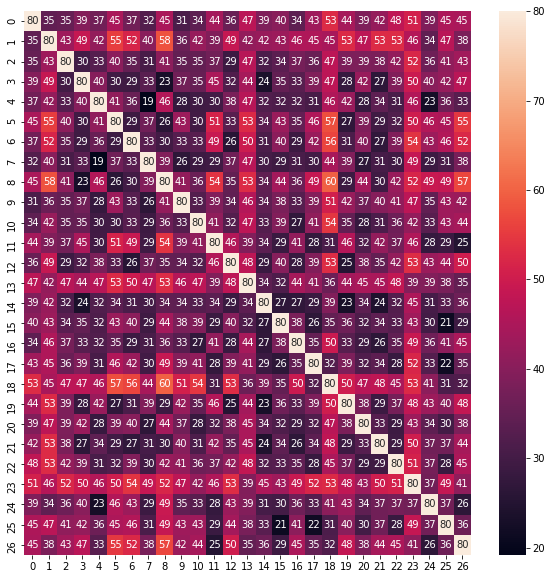

In [310]:
fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(data=similarities, ax=ax, annot=True)

In [311]:
# Initialize a list to keep track of the 10 smallest values and their indexes
min_values = []

# Iterate over the rows and columns of the table
for i in range(len(similarities)):
    for j in range(len(similarities[i])):
        # Add the current value and its indexes to the list
        min_values.append((similarities[i][j], (i, j)))
        
        # Sort the list in ascending order based on the values
        min_values = sorted(min_values, key=lambda x: x[0])
        
        # If the list has more than 10 elements, remove the last element
        if len(min_values) > 10:
            min_values.pop()

# Print the 10 pairs of indexes with the minimum value
print(min_values[:10])

[(19.192129749558248, (4, 7)), (19.192129749558248, (7, 4)), (21.13079096519965, (15, 25)), (21.13079096519965, (25, 15)), (21.591638262289965, (17, 25)), (21.591638262289965, (25, 17)), (22.543494192102134, (4, 24)), (22.543494192102134, (24, 4)), (23.043440758994826, (3, 8)), (23.043440758994826, (8, 3))]


In [312]:
X_train={}
X_test={}
y_train={}
y_test={}
for n in range(n_subj):
    # X features, y labels
    X_train[n], X_test[n], y_train[n], y_test[n] = train_test_split(emg_features_norm[n], labels_dict[n], test_size=0.2)

### Training on subject 4 and testing on subject 7

#### SVM Model

In [313]:
clf = svm.SVC(kernel='linear', verbose=True)
clf.fit(X_train[4], y_train[4])

[LibSVM]

SVC(kernel='linear', verbose=True)

In [314]:
y_hat=clf.predict(X_test[7])

error = len(np.where((y_hat-y_test[7])!=0)[0])
accuracy_svm = 1-(error/len(y_hat))
print("Accuracy of the SVM model trained on subject 4 and tested on subject 7: %.2f"%accuracy_svm)

Accuracy of the SVM model trained on subject 4 and tested on subject 7: 0.46


#### KNN Model

In [315]:
# init model
knn_model = KNeighborsClassifier(3)
# train model
knn_model.fit(X_train[4],y_train[4])

KNeighborsClassifier(n_neighbors=3)

In [316]:
y_hat=knn_model.predict(X_test[7])

error=len(np.where((y_hat-y_test[7])!=0)[0])
accuracy_knn = 1-(error/len(y_hat))
print("Accuracy of the KNN model trained on subject 4 and tested on subject 7: %.2f"%accuracy_knn)

Accuracy of the KNN model trained on subject 4 and tested on subject 7: 0.29


#### Random Forest Model

In [317]:
# init model
randomForest_model = RandomForestClassifier(max_depth=2, random_state=0)
# train model
randomForest_model.fit(X_train[5],y_train[5])

RandomForestClassifier(max_depth=2, random_state=0)

In [318]:
y_hat = randomForest_model.predict(X_test[7])

error = len(np.where((y_hat-y_test[7])!=0)[0])
accuracy_random = 1-(error/len(y_hat))
print("Accuracy of the Random Forest model trained on subject 4 and tested on subject 7: %.2f"%accuracy_random)

Accuracy of the Random Forest model trained on subject 4 and tested on subject 7: 0.12


# Task 4
**Train a classification model on a set of subjects and test it on a subject not belonging to the set. Do the same thing varying the number of subjects in the training set and discuss the classification performance.**